# Perform sentiment analysis using LSTM and Transformer Networks

## Importing Required Libraries and Modules

In [1]:
import os
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup   

2025-05-03 19:08:54.232062: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-03 19:08:54.244266: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746279534.259229   13953 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746279534.263528   13953 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746279534.275213   13953 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Configuring variables

In [2]:
dataPath  = "Data/IMDB Dataset.csv"
testDataPath = "Data/IMDB_Dataset_test.csv"
modelPath = "Model/lstm_model.keras"


In [3]:
data = pd.read_csv(dataPath)
# data =data[:2000]
test_samples = data.sample(n=200, random_state=42)
data = data.drop(test_samples.index)
test_samples.to_csv(testDataPath, index=False)

## Data understanding & preporcessing

In [4]:
print(data.shape)

(49800, 2)


In [5]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
data.review[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

## Checking Sentiment Distribution

In [7]:
data["sentiment"].value_counts()

negative    24905
positive    24895
Name: sentiment, dtype: int64

## Encoding Sentiment Labels

In [8]:
data.replace({"sentiment": {"positive": 1, "negative": 0}}, inplace=True)

## Preprocessing data

In [9]:
def cropHTML(text):
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()


def removePunc(text):

    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern,' ',text)

    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub(r'\s+', ' ', text)

    return text

def removeStopWord(text, updated_stopword_list ,is_lower_case=False):
    # splitting strings into tokens (list of words)
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        # filtering out the stop words
        filtered_tokens = [token for token in tokens if token not in updated_stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in updated_stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text
    
    
def Preprocess(text):
    text = cropHTML(text)
    text= removePunc(text)
#     stopword_list = nltk.corpus.stopwords.words('english')
#     print(stopword_list)
#     updated_stopword_list = []

#     for word in stopword_list:
#         if word=='not' or word.endswith("n't"):
#             pass
#         else:
#             updated_stopword_list.append(word)

#     text = removeStopWord(text , updated_stopword_list)
#     text=text.replace("RT" , '')
  
    return text


data["review"] =data['review'].apply(Preprocess)

In [10]:
data.review[0]

'One of the other reviewers has mentioned that after watching just 1 Oz episode you ll be hooked They are right as this is exactly what happened with me The first thing that struck me about Oz was its brutality and unflinching scenes of violence which set in right from the word GO Trust me this is not show for the faint hearted or timid This show pulls no punches with regards to drugs sex or violence Its is hardcore in the classic use of the word It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary It focuses mainly on Emerald City an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda Em City is home to many Aryans Muslims gangstas Latinos Christians Italians Irish and more so scuffles death stares dodgy dealings and shady agreements are never far away would say the main appeal of the show is due to the fact that it goes where other shows wouldn dare Forget pretty pictu

## Splitting Dataset into Train, Validation, and Test Sets

In [11]:
train, temp = train_test_split(data, test_size=0.20, random_state=42, stratify=data['sentiment'])
val, test = train_test_split(temp, test_size=0.50, random_state=42, stratify=temp['sentiment'])
len(train) , len(val) , len(test) 

(39840, 4980, 4980)

In [12]:
train.head()

,review,sentiment
35820,I a big fan of Italian films from the seventie...,0
40607,Starting with My Name is Joe like scene in Alc...,1
21931,Has some really good music and performances Ki...,0
30781,The Shirley Jackson novel The Haunting of Hill...,0
41881,Miss Cast Away is an amusing trifle which dis...,1


## Storing and Verifying Dataset Splits

In [13]:
train_data = train
val_data = val
test_data = test

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(39840, 2)
(4980, 2)
(4980, 2)


## Tokenizing and Padding Text Data

In [14]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data["review"])

X_train = pad_sequences(tokenizer.texts_to_sequences(train_data["review"]), maxlen=200)
X_val = pad_sequences(tokenizer.texts_to_sequences(val_data["review"]), maxlen=200)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data["review"]), maxlen=200)

# Target variables
Y_train = train_data["sentiment"].values
Y_val = val_data["sentiment"].values
Y_test = test_data["sentiment"].values

In [15]:
len(X_train[0]), X_train[0] , Y_train[0]

(200,
 array([2065,  755,   54, 1700, 1511,    3,   26,   53,   32,  112,  137,
          79,    8,   16,   14,   44, 1992,  191,    6,  532,  472, 1793,
           9,    8,    5, 2321, 1127,   16,    9,  210,  167,    4,  137,
        1655,  690, 1189,   56,  137,   79,    8,  996,   69,   47,   15,
           1,  189,    9,    8,    5, 1127,  215,   47,  629,   48,   17,
        1151,    9,    6,   78,  246,  763,    2,  606,    3,    1,   97,
          21,  220,   11,    1,  415, 3146,    1,   16, 2751,   18,    7,
           8,  420,   24,    9, 2250,    2,  514,    9,  681,   26,    1,
         107,    9,    8,   12,   42,    1,   16,  121,   23,  142, 4270,
         389,    4,    6,    2,    1,  316,    3,    6,   26,  105,   49,
         215,  610,   66,    6,  527,  184,   34,  956,    2,   67,  264,
           4,  265,  610,   44,  425,    3,  217,  255,  859,    9,  217,
           5,  153,  211,  610,   49,   66,  312, 2065,   18,  253,    5,
         209, 1664,    2,    9, 

## Building and Compiling the LSTM Model

In [16]:
# Build the model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
model.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=1, activation='sigmoid'))



# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)



# Train the model
history = model.fit(
    X_train, Y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping]
)

model.summary()


Epoch 1/10


/home/abbas/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-05-03 18:08:40.258862: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


623/623 ━━━━━━━━━━━━━━━━━━━━ 82s 128ms/step - accuracy: 0.7430 - loss: 0.5102 - val_accuracy: 0.8422 - val_loss: 0.3752
Epoch 2/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 76s 123ms/step - accuracy: 0.8638 - loss: 0.3351 - val_accuracy: 0.8598 - val_loss: 0.3314
Epoch 3/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 74s 119ms/step - accuracy: 0.8843 - loss: 0.2864 - val_accuracy: 0.8765 - val_loss: 0.3104
Epoch 4/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 77s 124ms/step - accuracy: 0.9058 - loss: 0.2408 - val_accuracy: 0.8833 - val_loss: 0.3032
Epoch 5/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 76s 122ms/step - accuracy: 0.9169 - loss: 0.2191 - val_accuracy: 0.8841 - val_loss: 0.2916
Epoch 6/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 78s 125ms/step - accuracy: 0.9194 - loss: 0.2068 - val_accuracy: 0.8849 - val_loss: 0.3091
Epoch 7/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 77s 123ms/step - accuracy: 0.9372 - loss: 0.1661 - val_accuracy: 0.8823 - val_loss: 0.3170
Epoch 8/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 78s 125ms/step - accuracy: 0.9453 - loss: 0.1430 - val

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,068,421 (7.89 MB)

 Trainable params: 689,473 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,378,948 (5.26 MB)

## Visualizing Training and Validation Accuracy/Loss Over Epochs

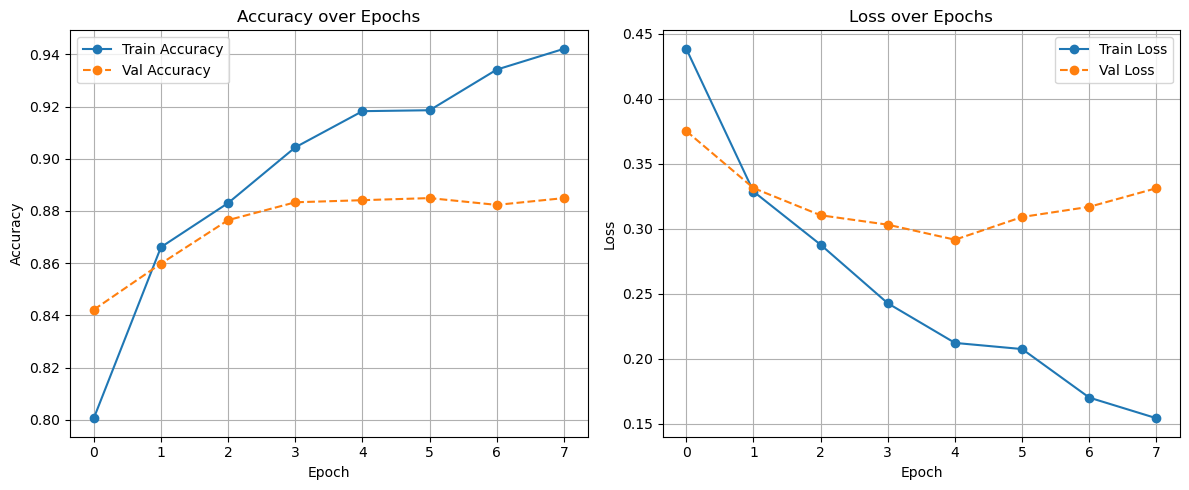

In [18]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', linestyle='--', marker='o') 
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', linestyle='--', marker='o')  
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Saving the Trained Model

In [19]:
model.save(modelPath)

## Loading the model & data for evaluation on the data which we saved earlier

In [20]:
from tensorflow.keras.models import load_model

model = load_model(modelPath)


In [40]:
test= pd.read_csv(testDataPath)
test['sentiment'] = test['sentiment'].apply(lambda x : 1 if x == "positive" else 0)
test['review'] = test['review'].apply(Preprocess)
text = pad_sequences(tokenizer.texts_to_sequences(test["review"]), maxlen=200)
labels = test.sentiment.values

In [41]:
test

,review,sentiment
0,I really liked this Summerslam due to the look...,1
1,Not many television shows appeal to quite as m...,1
2,The film quickly gets to major chase scene wit...,0
3,Jane Austen would definitely approve of this o...,1
4,Expectations were somewhat high for me when we...,0
...,...,...
195,Code 46 is one of those scifi movies where the...,0
196,The Ali character works brilliantly within the...,1
197,Can anybody do good CGI films besides Pixar me...,0
198,I had no idea what this film was about or even...,1


## Visualizing Confusion Matrix

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


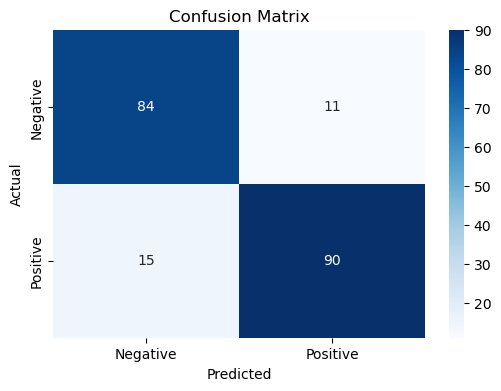

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test data
y_pred_probs = model.predict(text)
y_pred = (y_pred_probs > 0.5).astype("int32")

# Create confusion matrix
cm = confusion_matrix(labels, y_pred)

# Display with seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Predicting Sentiment for User Input

In [45]:
def predict_sentiment(model ,review):

    review = review.lower().strip()
    review= Preprocess(review)
    sequence = tokenizer.texts_to_sequences([review])
    padded_sequence = pad_sequences(sequence, maxlen=200)
    # Predict sentiment
    prediction = model.predict(padded_sequence)
    prob = prediction[0][0]
    sentiment = "positive" if prob > 0.5 else "negative"
    return sentiment, prob

## Inputs

In [30]:
review = "THis is great movie m but the ending is suspencefull ."
review2 ="I am not going to watch this movie ever"

In [32]:
sentiment, confidence = predict_sentiment(model ,review)
print(f"The sentiment of the review is: {sentiment} (confidence: {confidence:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
The sentiment of the review is: positive (confidence: 0.71)


In [34]:
sentiment, confidence = predict_sentiment(model , review2)
print(f"The sentiment of the review is: {sentiment} (confidence: {confidence:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
The sentiment of the review is: negative (confidence: 0.33)


# TRANSFORMERSSSSs

## Loading Libraries & Setting up variables

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import load_dataset
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
import re
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Dense, Embedding, LSTM, GRU ,SpatialDropout1D
import pandas.testing as tm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [17]:
vocab_size = 20000  
maxlen = 200 
batch_size = 32
embed_dim = 32
num_heads = 2 
ff_dim = 64  # Hidden layer size in feed forward network inside transformer


##  Training Blocks 

In [37]:

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, embedding_matrix=None, trainable=False, **kwargs):
        super().__init__(**kwargs)

     
        if embedding_matrix is not None:
            self.token_emb = layers.Embedding(
                input_dim=vocab_size,
                output_dim=embed_dim,
                weights=[embedding_matrix], 
                trainable=trainable         )
        else:
          
            self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        
    
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
      
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        
      
        x = self.token_emb(x)
        
  
        return x + positions

def create_embedding_matrix(word_index, embeddings_index, embedding_dim, vocab_size):
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        if i >= vocab_size:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

def load_glove_embeddings(glove_file_path, embedding_dim):
    embeddings_index = {}
    with open(glove_file_path, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")
    return embeddings_index


##  Data is being used which is used in LSTM training above . 

In [40]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production The filming tech...,1
2,I thought this was wonderful way to spend time...,1
3,Basically there a family where little boy Jake...,0
4,Petter Mattei Love in the Time of Money is vis...,1


## Initiating tokenizer

In [19]:
vocab_size = 20000
maxlen = 200
embedding_dim = 100 

train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['review'].values, data['sentiment'].values, test_size=0.2, random_state=42
)
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

X_train = tokenizer.texts_to_sequences(train_texts)
X_val = tokenizer.texts_to_sequences(val_texts)

X_train = pad_sequences(X_train, maxlen=maxlen, padding='post')
X_val = pad_sequences(X_val, maxlen=maxlen, padding='post')

y_train = np.array(train_labels)
y_val = np.array(val_labels)


## Embeddings

In [20]:
def load_glove_embeddings(glove_file_path, embedding_dim):
    embeddings_index = {}
    with open(glove_file_path, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index

def create_embedding_matrix(word_index, embeddings_index, embedding_dim, vocab_size):
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        if i >= vocab_size:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

# Load GloVe
glove_path = 'embedding/glove.6B.100d.txt'  # Change this path if needed
embeddings_index = load_glove_embeddings(glove_path, embedding_dim)

# Create embedding matrix
embedding_matrix = create_embedding_matrix(tokenizer.word_index, embeddings_index, embedding_dim, vocab_size)


In [39]:
len(embedding_matrix[0]) , len(embedding_matrix)

(100, 20000)

In [30]:
embedding_matrix[4]

array([-0.1529    , -0.24279   ,  0.89837003,  0.16996001,  0.53516001,
        0.48784   , -0.58825999, -0.17982   , -1.35810006,  0.42541   ,
        0.15377   ,  0.24214999,  0.13474   ,  0.41192999,  0.67043   ,
       -0.56418002,  0.42985001, -0.012183  , -0.11677   ,  0.31781   ,
        0.054177  , -0.054273  ,  0.35516   , -0.30241001,  0.31434   ,
       -0.33846   ,  0.71714997, -0.26855001, -0.15837   , -0.47466999,
        0.051581  , -0.33252001,  0.15003   , -0.12989999, -0.54617   ,
       -0.37843001,  0.64261001,  0.82187003, -0.080006  ,  0.078479  ,
       -0.96976   , -0.57740998,  0.56490999, -0.39873001, -0.057099  ,
        0.19743   ,  0.065706  , -0.48091999, -0.20125   , -0.40834001,
        0.39456001, -0.02642   , -0.11838   ,  1.01199996, -0.53171003,
       -2.74740005, -0.042981  , -0.74848998,  1.75740004,  0.59085   ,
        0.04885   ,  0.78267002,  0.38497001,  0.42096999,  0.67882001,
        0.10337   ,  0.63279998, -0.026595  ,  0.58647001, -0.44

## Transformer Block

In [78]:
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
    

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, embedding_matrix=None, trainable=False):
        super().__init__()
        if embedding_matrix is not None:
            self.token_emb = layers.Embedding(
                input_dim=vocab_size,
                output_dim=embed_dim,
                weights=[embedding_matrix],
                trainable=trainable
            )
        else:
            self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "maxlen": self.maxlen,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
            "trainable": self.trainable_embedding,
            
        })
        return config

    
    def call(self, x):
        positions = tf.range(start=0, limit=tf.shape(x)[-1], delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    
    


In [34]:
# Compiling the Model

In [85]:
inputs = layers.Input(shape=(maxlen,))
x = TokenAndPositionEmbedding(maxlen, vocab_size, embedding_dim, embedding_matrix, trainable=False)(inputs)
x = TransformerBlock(embed_dim=embedding_dim, num_heads=2, ff_dim=64)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_1  │ (None, 200, 100)       │     2,020,000 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 200, 100)       │        94,064 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 100)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 20)             │         2,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,116,105 (8.07 MB)

 Trainable params: 116,105 (453.54 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

In [33]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)


Epoch 1/5
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 95s 75ms/step - accuracy: 0.7495 - loss: 0.4901 - val_accuracy: 0.8397 - val_loss: 0.3741
Epoch 2/5
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 96s 77ms/step - accuracy: 0.8438 - loss: 0.3610 - val_accuracy: 0.8398 - val_loss: 0.3703
Epoch 3/5
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 98s 79ms/step - accuracy: 0.8442 - loss: 0.3559 - val_accuracy: 0.8424 - val_loss: 0.3585
Epoch 4/5
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 104s 84ms/step - accuracy: 0.8497 - loss: 0.3452 - val_accuracy: 0.8462 - val_loss: 0.3486
Epoch 5/5
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 104s 84ms/step - accuracy: 0.8559 - loss: 0.3358 - val_accuracy: 0.8534 - val_loss: 0.3357


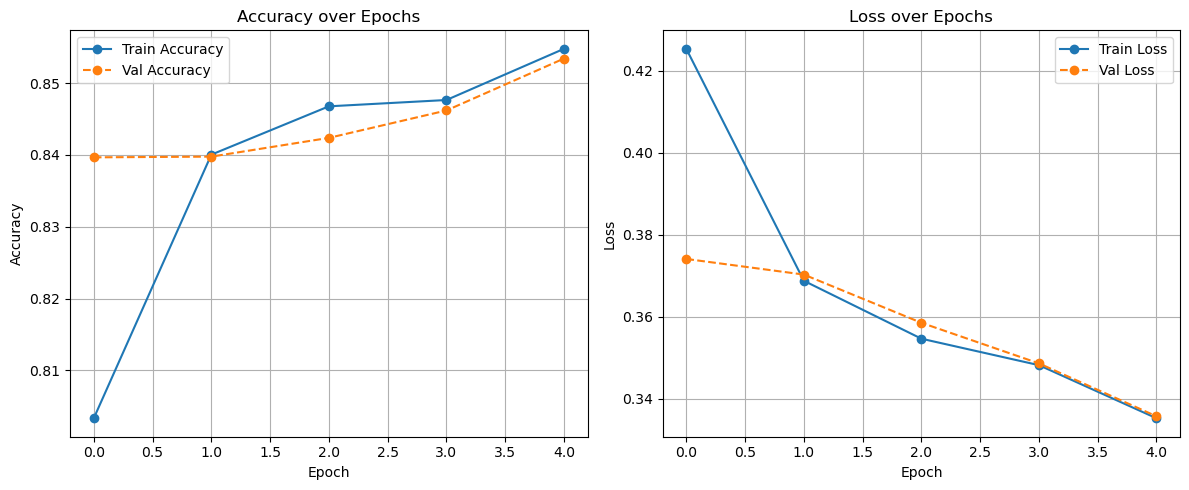

In [51]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', linestyle='--', marker='o') 
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', linestyle='--', marker='o')  
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Evaluating model on the data used earlier 

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


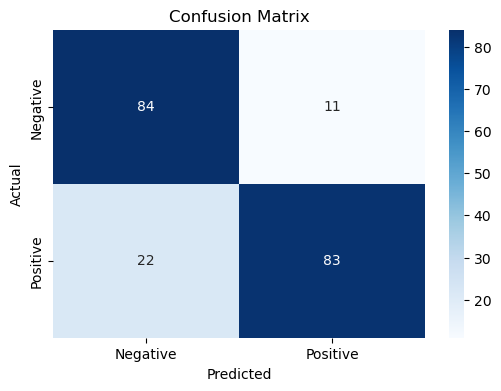

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt


y_pred_probs = model.predict(text)
y_pred = (y_pred_probs > 0.5).astype("int32")

# Create confusion matrix
cm = confusion_matrix(labels, y_pred)

# Display with seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Inferencing 

In [49]:
sample = "i love this movie "
sample2 = "This is disgusting movie , Made me feel sick"
sample3 ="This movie is a inspirational work of art which many recent movies dont do"


In [50]:
sentiment, confidence = predict_sentiment(model ,sample)
print(f"The sentiment of the review is: {sentiment} (confidence: {confidence:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
The sentiment of the review is: positive (confidence: 0.79)


In [47]:
sentiment, confidence = predict_sentiment(model ,sample2)
print(f"The sentiment of the review is: {sentiment} (confidence: {confidence:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
The sentiment of the review is: negative (confidence: 0.01)


In [48]:
sentiment, confidence = predict_sentiment(model ,sample3)
print(f"The sentiment of the review is: {sentiment} (confidence: {confidence:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
The sentiment of the review is: positive (confidence: 0.82)


In [53]:
# print(tokenizer.word_index.get("inspirational"))
# print(tokenizer.word_index.get("hate"))

## Sving the model

In [86]:
from tensorflow.keras.utils import get_custom_objects

# get_custom_objects().update({'TokenAndPositionEmbedding': TokenAndPositionEmbedding})

model.save("Model/sentiment_transformer_model.keras")
